# Off-Road Desert Semantic Segmentation Pipeline

Multiclass semantic segmentation using DeepLabV3+ with EfficientNet-B0.  
Consolidated from: `dataset.py`, `model.py`, `losses.py`, `metrics.py`, `train.py`, `infer.py`, `visualize.py`

## 1. Imports & Environment Setup

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.amp import autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Global Configuration

In [2]:

# Paths — adjust DATA_ROOT if your dataset lives elsewhere
DATA_ROOT = "dataset"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# Hyperparameters — identical to the original train.py defaults
EPOCHS = 30
BATCH_SIZE = 4 # from 8 to 4
LR = 1e-4
IMG_SIZE = 512 # from 256 to 512
NUM_WORKERS = 0

## 3. Class ID Mapping

Mask pixel values are non-contiguous IDs: `{100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000}`.  
We remap them to contiguous `[0–9]` via a lookup table for O(1) per-pixel mapping.

In [ ]:
# Original class IDs found in the masks -> contiguous labels [0-9]
CLASS_IDS = [100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]
NUM_CLASSES = len(CLASS_IDS)

# Build a lookup table for fast remapping (max value is 10000, so table size is 10001)
_REMAP_LUT = np.full(10001, 0, dtype=np.int64)  # default to 0 for any unexpected value
for contiguous_label, original_id in enumerate(CLASS_IDS):
    _REMAP_LUT[original_id] = contiguous_label


def remap_mask(mask: np.ndarray) -> np.ndarray:
    """Remap raw mask pixel values to contiguous class indices [0, NUM_CLASSES-1]."""
    return _REMAP_LUT[mask]


print(f"Classes: {NUM_CLASSES}")
print(f"ID mapping: {dict(zip(CLASS_IDS, range(NUM_CLASSES)))}")

Classes: 10
ID mapping: {100: 0, 200: 1, 300: 2, 500: 3, 550: 4, 600: 5, 700: 6, 800: 7, 7100: 8, 10000: 9}


## 4. Dataset Class

Pairs images and masks by **sorted index** — filenames do NOT match between `Color_Images/` and `segmentation/`.  
Masks are loaded as uint16 (values like 7100 and 10000 exceed uint8 range).

In [4]:
class SegmentationDataset(Dataset):
    """
    Pairs images and masks by SORTED INDEX, not by filename.
    This is required because filenames differ between the two folders.
    """

    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Sort both lists independently — alignment is by index
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        assert len(self.images) == len(self.masks), (
            f"Mismatch: {len(self.images)} images vs {len(self.masks)} masks"
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image as RGB (OpenCV loads BGR by default)
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as uint16 grayscale — critical for values > 255 like 7100, 10000
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # If mask was loaded as 3-channel, take first channel
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Remap to contiguous class IDs [0-9]
        mask = remap_mask(mask).astype(np.int64)

        # Apply augmentations — Albumentations treats mask as integer labels automatically
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]           # float32 tensor [3, H, W]
            mask = augmented["mask"]             # int64 tensor [H, W]

        # Ensure mask is LongTensor for CrossEntropyLoss / segmentation losses
        mask = mask.long() if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).long()

        return image, mask

## 5. Data Augmentation

In [5]:
def get_train_transforms(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        # Spatial shifts force the model to learn shapes, not exact pixel locations
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        # Desert lighting is harsh; randomize shadows and glare heavily
        A.RandomShadow(p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        # Blur/Noise to destroy "perfect" synthetic textures
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
            A.ImageCompression(quality_lower=85, quality_upper=95, p=1.0)
        ], p=0.4),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


def get_val_transforms(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

## 6. DataLoaders

In [6]:
train_ds = SegmentationDataset(
    image_dir=os.path.join(DATA_ROOT, "train", "Color_Images"),
    mask_dir=os.path.join(DATA_ROOT, "train", "segmentation"),
    transform=get_train_transforms(IMG_SIZE),
)
val_ds = SegmentationDataset(
    image_dir=os.path.join(DATA_ROOT, "val", "Color_Images"),
    mask_dir=os.path.join(DATA_ROOT, "val", "segmentation"),
    transform=get_val_transforms(IMG_SIZE),
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,drop_last=True
)

print(f"Train: {len(train_ds)} samples | Val: {len(val_ds)} samples")

Train: 2857 samples | Val: 317 samples


f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\dhmal\AppData\Local\Temp\ipykernel_21880\2672134211.py:15: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=95, p=1.0)


## 7. Model Definition

DeepLabV3+ with ImageNet-pretrained EfficientNet-B0 encoder via `segmentation-models-pytorch`.

In [ ]:
def build_model():
    model = smp.DeepLabV3Plus(
        encoder_name="resnet50",    # efficientnetB0 to resnet50    
        encoder_weights="ssl",      # Swapped from 'imagenet' to 'ssl' (Self-Supervised Learning)
        in_channels=3,
        classes=NUM_CLASSES,              
        encoder_output_stride=16,                                
    )
    return model

model = build_model().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

f:\#Project\Krackhack\KrackHack\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dhmal\.cache\huggingface\hub\models--smp-hub--resnet50.ssl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model parameters: 26,679,898


## 8. Loss Functions

Combined Dice + Focal loss.  
- Dice: optimizes region overlap, handles class imbalance.  
- Focal: down-weights easy pixels, focuses on hard examples.

In [8]:
class DiceFocalLoss(nn.Module):
    """Dice + Focal combined loss for multiclass segmentation."""

    def __init__(self):
        super().__init__()
        # mode="multiclass" expects predictions [B, C, H, W] and targets [B, H, W] with class indices
        self.dice = smp.losses.DiceLoss(mode="multiclass", classes=NUM_CLASSES)
        self.focal = smp.losses.FocalLoss(mode="multiclass")

    def forward(self, pred, target):
        return self.dice(pred, target) + self.focal(pred, target)


criterion = DiceFocalLoss()

## 9. Metrics

Multiclass IoU (Jaccard Index) — accumulated across batches, computed per-epoch.

In [10]:
class MulticlassIoU:
    """Accumulates predictions over batches, then computes mean IoU."""

    def __init__(self, num_classes=NUM_CLASSES):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        """Clear accumulators at the start of each epoch."""
        self.intersection = np.zeros(self.num_classes)
        self.union = np.zeros(self.num_classes)

    def update(self, pred: torch.Tensor, target: torch.Tensor):
        """
        Args:
            pred: raw logits [B, C, H, W]
            target: class indices [B, H, W]
        """
        # Convert logits to predicted class indices
        pred_classes = pred.argmax(dim=1).cpu().numpy()  # [B, H, W]
        target_np = target.cpu().numpy()                  # [B, H, W]

        for cls in range(self.num_classes):
            pred_mask = (pred_classes == cls)
            target_mask = (target_np == cls)
            self.intersection[cls] += np.logical_and(pred_mask, target_mask).sum()
            self.union[cls] += np.logical_or(pred_mask, target_mask).sum()

    def compute(self):
        """Return mean IoU across all classes. Ignores classes with zero union."""
        iou_per_class = np.zeros(self.num_classes)
        for cls in range(self.num_classes):
            if self.union[cls] > 0:
                iou_per_class[cls] = self.intersection[cls] / self.union[cls]
        mean_iou = iou_per_class.mean()
        return mean_iou, iou_per_class


metric = MulticlassIoU()

## 10. Training Loop

In [11]:

# --- REPLACE YOUR EXISTING train_one_epoch FUNCTION ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    print("Training Epoch")
    model.train()
    running_loss = 0.0

    # (Removed the buggy debug loop with the 'break' statement)

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            preds = model(images)
            loss = criterion(preds, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    # Fix: Calculate loss using actual batches processed because drop_last=True
    total_samples = len(loader) * loader.batch_size 
    return running_loss / total_samples

## 11. Validation Loop

In [12]:

# --- REPLACE YOUR EXISTING validate FUNCTION ---
@torch.no_grad()
def validate(model, loader, criterion, metric, device):
    model.eval()
    running_loss = 0.0
    metric.reset()

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            preds = model(images)
            loss = criterion(preds, masks)

        running_loss += loss.item() * images.size(0)
        metric.update(preds, masks)

    # Fix: Same drop_last math correction here
    total_samples = len(loader) * loader.batch_size
    val_loss = running_loss / total_samples
    mean_iou, per_class_iou = metric.compute()
    return val_loss, mean_iou, per_class_iou

## 12. Training Execution

In [ ]:
# --- OPTIMIZED DIFFERENTIAL LEARNING RATES ---
# model.encoder holds the ResNet-50 weights
# model.decoder and model.segmentation_head hold the untrained DeepLabV3+ layers

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},           # 10x smaller: Gently fine-tune structural weights
    {'params': model.decoder.parameters(), 'lr': 1e-4},           # Normal speed: Learn the contextual relationships
    {'params': model.segmentation_head.parameters(), 'lr': 1e-3}  # Fast: Learn the 10 off-road classes quickly
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = GradScaler(enabled=(device.type == "cuda"))

best_miou = 0.0
history = {"train_loss": [], "val_loss": [], "val_miou": []}

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_miou, per_class_iou = validate(model, val_loader, criterion, metric, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_miou"].append(val_miou)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val mIoU: {val_miou:.4f}")

    # Print per-class IoU every 10 epochs for monitoring
    if epoch % 10 == 0 or epoch == 1:
        for cls_idx, iou_val in enumerate(per_class_iou):
            print(f"  Class {CLASS_IDS[cls_idx]:>5d} (idx {cls_idx}): IoU = {iou_val:.4f}")

    # Save best model
    if val_miou > best_miou:
        best_miou = val_miou
        save_path = os.path.join(SAVE_DIR, "best_model.pth")
        torch.save(model.state_dict(), save_path)
        print(f"  -> Saved best model (mIoU={best_miou:.4f})")

# Save final checkpoint
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "final_model.pth"))
print(f"\nTraining complete. Best mIoU: {best_miou:.4f}")

C:\Users\dhmal\AppData\Local\Temp\ipykernel_21880\3086418045.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Training Epoch
Epoch 1/30 | Train Loss: 0.9568 | Val Loss: 0.7226 | Val mIoU: 0.4715
  Class   100 (idx 0): IoU = 0.7514
  Class   200 (idx 1): IoU = 0.5456
  Class   300 (idx 2): IoU = 0.6086
  Class   500 (idx 3): IoU = 0.3375
  Class   550 (idx 4): IoU = 0.2411
  Class   600 (idx 5): IoU = 0.4641
  Class   700 (idx 6): IoU = 0.0000
  Class   800 (idx 7): IoU = 0.2099
  Class  7100 (idx 8): IoU = 0.5793
  Class 10000 (idx 9): IoU = 0.9778
  -> Saved best model (mIoU=0.4715)
Training Epoch
Epoch 2/30 | Train Loss: 0.7887 | Val Loss: 0.6514 | Val mIoU: 0.5124
  -> Saved best model (mIoU=0.5124)
Training Epoch
Epoch 3/30 | Train Loss: 0.7302 | Val Loss: 0.6169 | Val mIoU: 0.5543
  -> Saved best model (mIoU=0.5543)
Training Epoch
Epoch 4/30 | Train Loss: 0.7029 | Val Loss: 0.5991 | Val mIoU: 0.5740
  -> Saved best model (mIoU=0.5740)
Training Epoch
Epoch 5/30 | Train Loss: 0.6661 | Val Loss: 0.5789 | Val mIoU: 0.5857
  -> Saved best model (mIoU=0.5857)
Training Epoch
Epoch 6/30 | Train L

## 13. Visualization & Inference

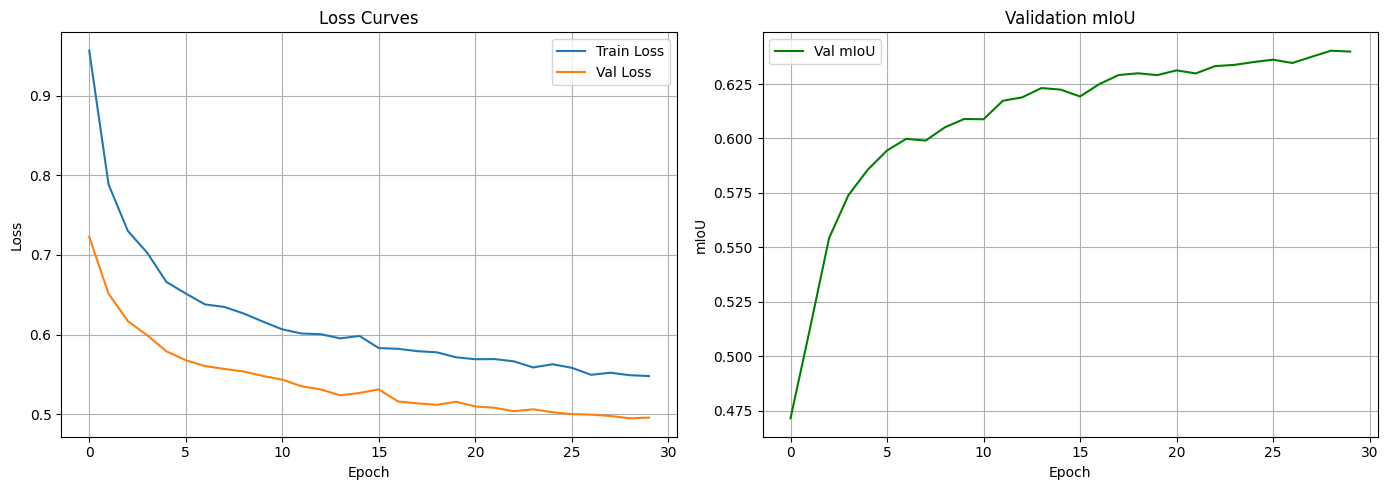

In [14]:
# --- Training curves ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curves")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history["val_miou"], label="Val mIoU", color="green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("mIoU")
axes[1].set_title("Validation mIoU")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150)
plt.show()

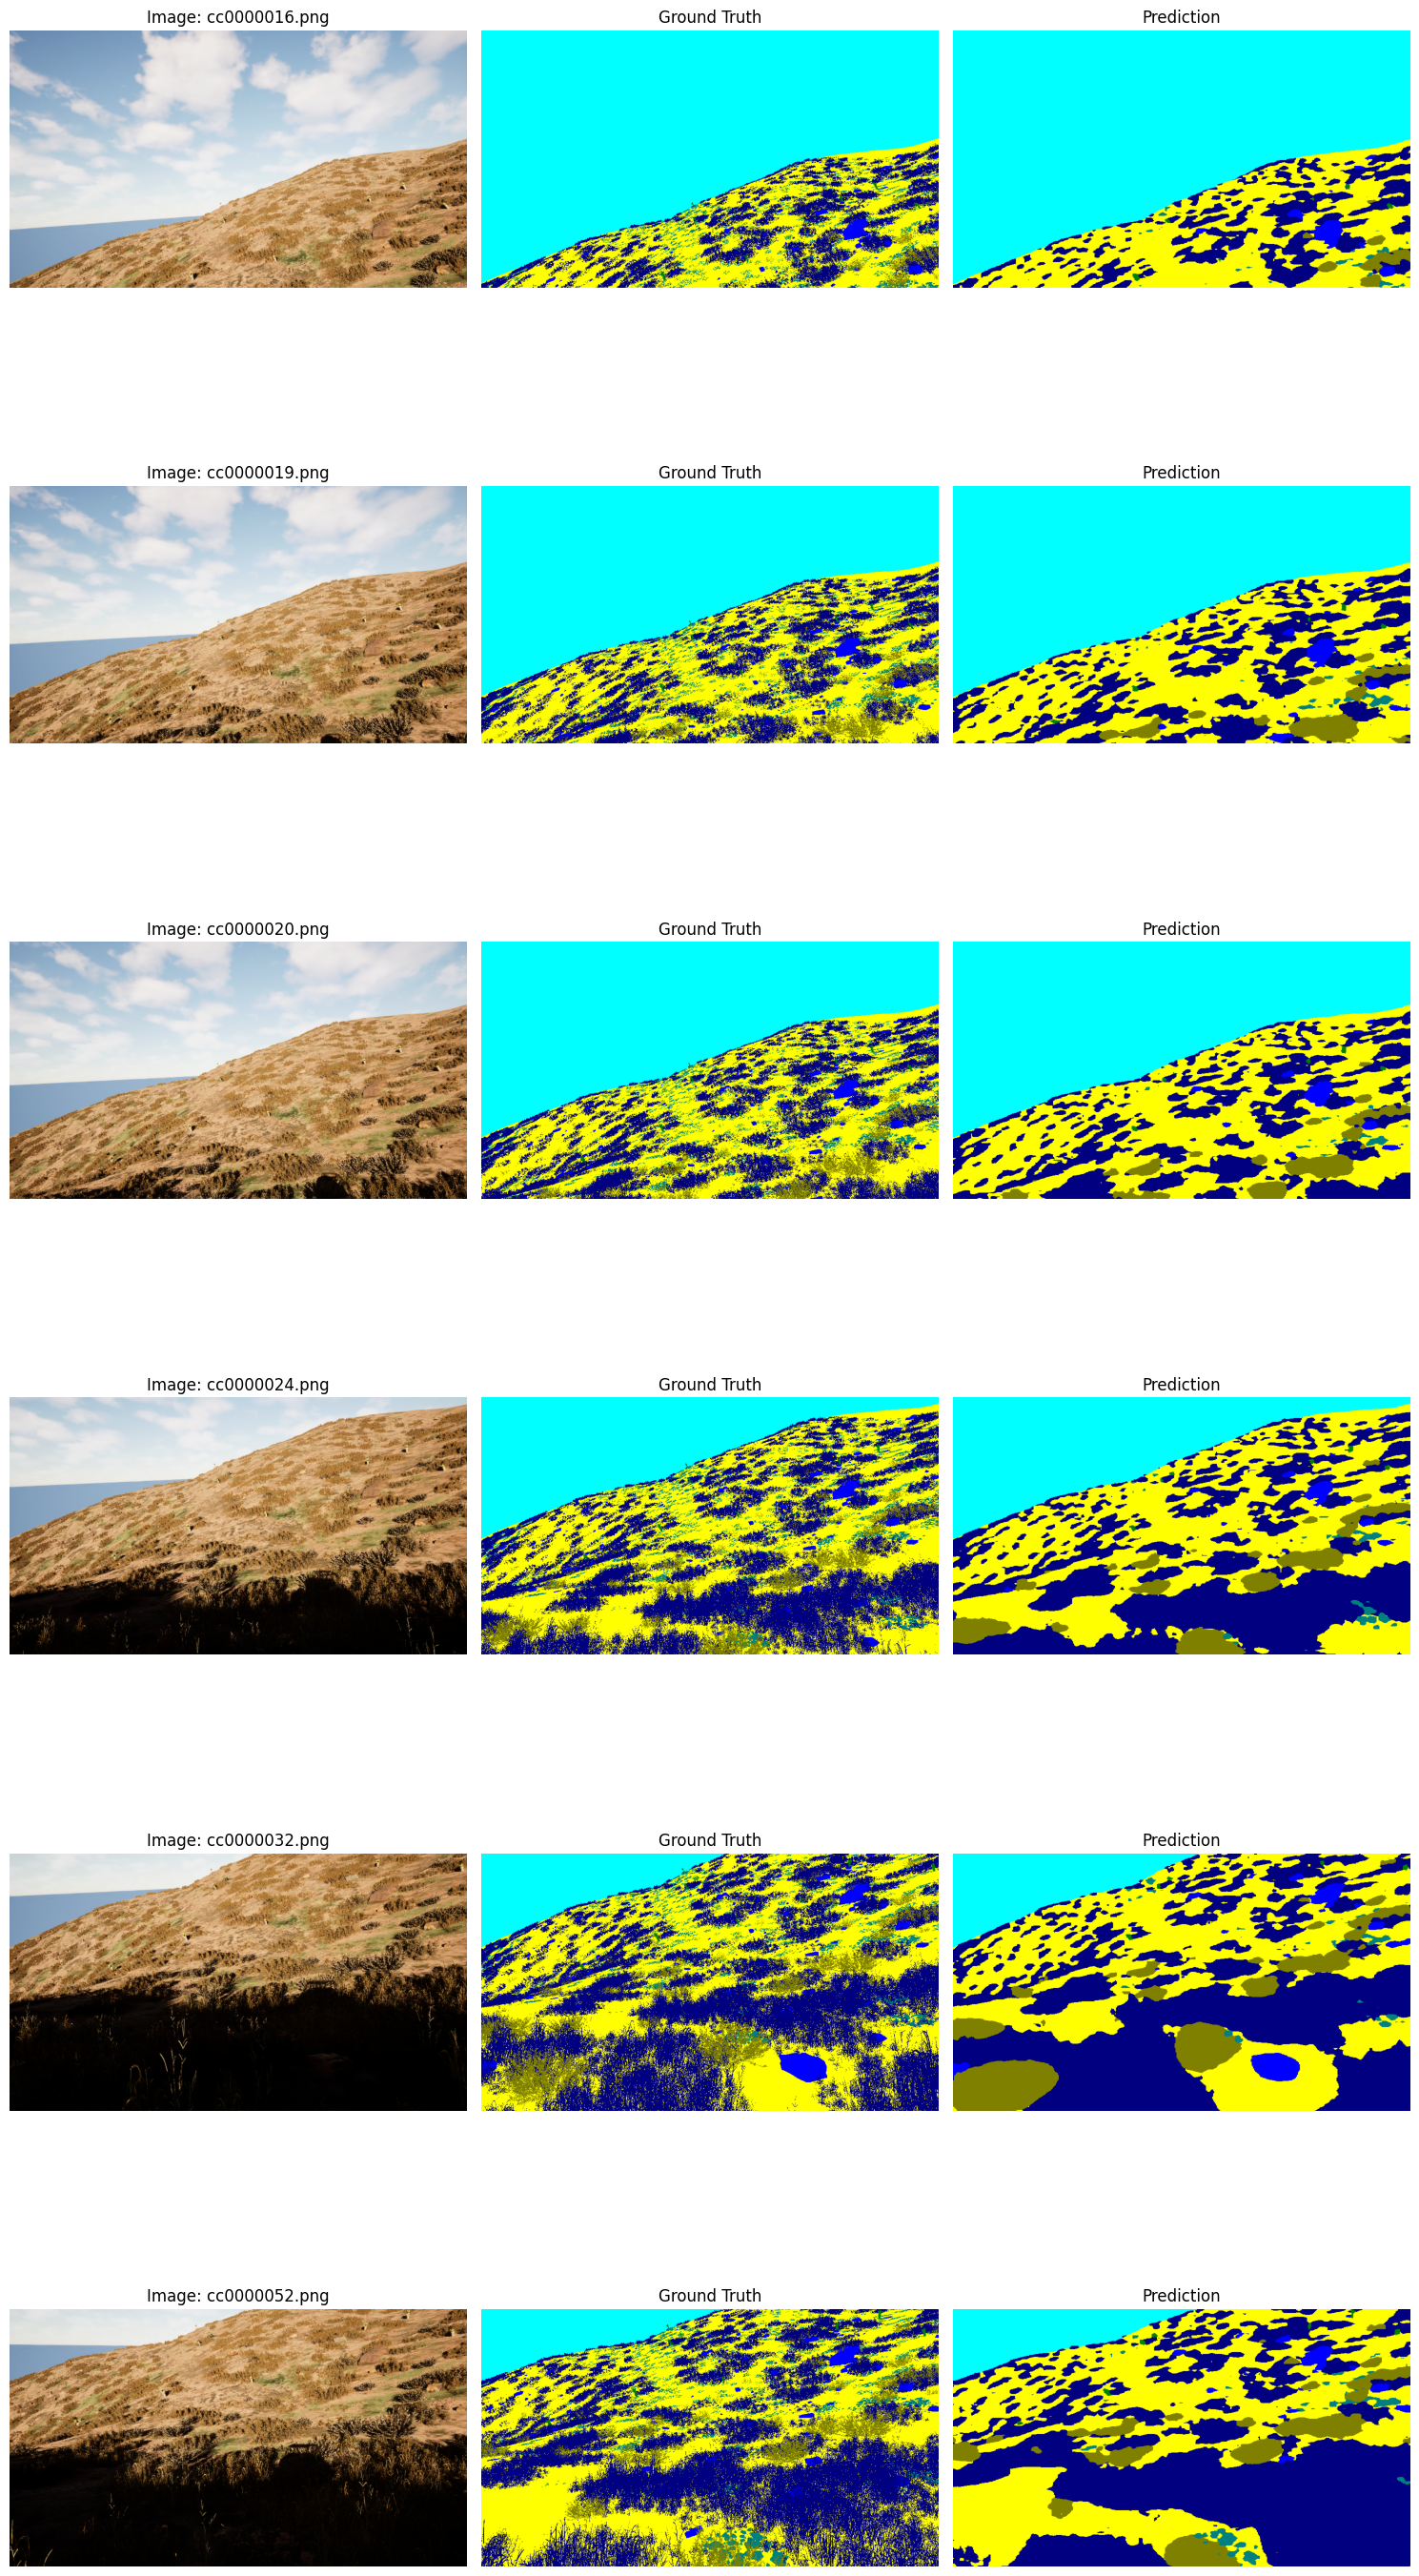

In [15]:
# --- Visual inference on validation samples ---

# Distinct colors for each class (RGB for matplotlib)
CLASS_COLORS = [
    (128,   0,   0),    # 100  - dark red
    (  0, 128,   0),    # 200  - green
    (  0,   0, 128),    # 300  - dark blue
    (128, 128,   0),    # 500  - yellow-ish
    (  0, 128, 128),    # 550  - cyan-ish
    (128,   0, 128),    # 600  - magenta
    (  0, 255,   0),    # 700  - bright green
    (  0,   0, 255),    # 800  - blue
    (255, 255,   0),    # 7100 - yellow
    (  0, 255, 255),    # 10000- cyan
]


def colorize_mask(mask: np.ndarray) -> np.ndarray:
    """Convert class-index mask to a colored RGB image."""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx in range(NUM_CLASSES):
        colored[mask == cls_idx] = CLASS_COLORS[cls_idx]
    return colored


def postprocess_mask(mask: np.ndarray) -> np.ndarray:
    """
    Morphological post-processing to clean up noisy predictions.
    Applies per-class opening (remove small spurious pixels)
    followed by closing (fill small holes).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = np.zeros_like(mask)

    for cls in range(NUM_CLASSES):
        binary = (mask == cls).astype(np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        cleaned[binary == 1] = cls

    return cleaned


def remap_to_original(mask: np.ndarray) -> np.ndarray:
    """Convert contiguous labels [0-9] back to original class IDs for submission."""
    out = np.zeros_like(mask, dtype=np.uint16)
    for idx, original_id in enumerate(CLASS_IDS):
        out[mask == idx] = original_id
    return out


# Load best model for inference
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_model.pth"), map_location=device, weights_only=True))
model.eval()

# Inference transform (same as val — resize + normalize only)
infer_transform = get_val_transforms(IMG_SIZE)

# Pick a few validation samples
val_image_dir = os.path.join(DATA_ROOT, "val", "Color_Images")
val_mask_dir = os.path.join(DATA_ROOT, "val", "segmentation")
val_images = sorted(os.listdir(val_image_dir))
val_masks = sorted(os.listdir(val_mask_dir))

NUM_SAMPLES = 6
fig, axes = plt.subplots(NUM_SAMPLES, 3, figsize=(15, 5 * NUM_SAMPLES))
if NUM_SAMPLES == 1:
    axes = axes[np.newaxis, :]  # ensure 2D indexing

for i in range(NUM_SAMPLES):
    # Load original image
    img_path = os.path.join(val_image_dir, val_images[i])
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    original_h, original_w = image_rgb.shape[:2]

    # Load ground truth mask
    gt_path = os.path.join(val_mask_dir, val_masks[i])
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
    if gt_mask.ndim == 3:
        gt_mask = gt_mask[:, :, 0]
    gt_mask = remap_mask(gt_mask).astype(np.uint8)

    # Run inference
    augmented = infer_transform(image=image_rgb)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    with torch.no_grad(), autocast(device_type="cuda", enabled=(device.type == "cuda")):
        logits = model(input_tensor)

    pred_mask = logits.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    # Resize prediction back to original image dimensions
    pred_mask = cv2.resize(pred_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    # Plot: original | ground truth | prediction
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title(f"Image: {val_images[i]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(colorize_mask(gt_mask))
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(colorize_mask(pred_mask))
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.savefig("inference_results.png", dpi=150)
plt.show()

## 14. Notes

**Dataset**
- 2857 train / 317 val image-mask pairs
- Masks are uint16 PNGs — loaded with `cv2.IMREAD_UNCHANGED` to preserve values > 255
- Images and masks paired by sorted index, NOT by filename

**Architecture**
- DeepLabV3+ with EfficientNet-B0 encoder (ImageNet pretrained)
- 10 semantic classes remapped from `{100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000}` to `[0-9]`

**Training**
- Dice + Focal combined loss
- Adam optimizer, lr=1e-4
- Mixed precision (AMP) for GPU acceleration
- Best model saved by validation mIoU

**Augmentations** (train only)
- HorizontalFlip, RandomBrightnessContrast, ColorJitter, GaussNoise
- Both train and val: Resize to 256x256, ImageNet normalization

**Post-processing**
- Morphological opening + closing to clean noisy predictions
- `remap_to_original()` converts contiguous labels back to original class IDs for submission